# Initialize a game

In [8]:
from ConnectN import ConnectN

game_setting = {'size':(6,6), 'N':4, 'pie_rule':True}
game = ConnectN(**game_setting)


<IPython.core.display.Javascript object>


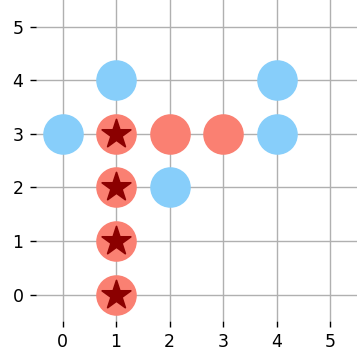

In [9]:
%matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Define our policy

Please go ahead and define your own policy! See if you can train it under 1000 games and with only 1000 steps of exploration in each move.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np

from ConnectN import ConnectN
game_setting = {'size':(6,6), 'N':4}
game = ConnectN(**game_setting)

class Policy(nn.Module):

    def __init__(self, game):
        super(Policy, self).__init__()

        # input = 6x6 board
        # convert to 5x5x8
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        # 5x5x16 to 3x3x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, bias=False)

        self.size=3*3*32
        
        # the part for actions
        self.fc_action1 = nn.Linear(self.size, self.size//4)
        self.fc_action2 = nn.Linear(self.size//4, 36)
        
        # the part for the value function
        self.fc_value1 = nn.Linear(self.size, self.size//6)
        self.fc_value2 = nn.Linear(self.size//6, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):

        y = F.leaky_relu(self.conv1(x))
        y = F.leaky_relu(self.conv2(y))
        y = y.view(-1, self.size)
        
        # action head
        a = self.fc_action2(F.leaky_relu(self.fc_action1(y)))
        
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.view(-1, 36)
        maxa = torch.max(a)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
        
        # value head
        value = self.tanh_value(self.fc_value2(F.leaky_relu( self.fc_value1(y) )))
        return prob.view(6,6), value

policy = Policy(game)


# Define a MCTS player for Play

In [11]:
import MCTS

from copy import copy

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move

import random

def Random_Player(game):
    return random.choice(game.available_moves())    


# Play a game against a random policy

<IPython.core.display.Javascript object>


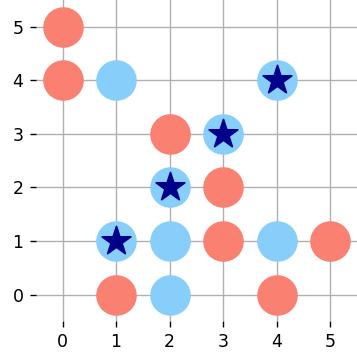

In [12]:
%matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=Policy_Player_MCTS, 
              player2=None)


# Training

In [6]:
# initialize our alphazero agent and optimizer
import torch.optim as optim

game=ConnectN(**game_setting)
policy = Policy(game)
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-5)

! pip install progressbar

Beware, training is **VERY VERY** slow!!

In [ ]:
# train our agent

from collections import deque
import MCTS

# try a higher number
episodes = 2000

import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

outcomes = []
policy_loss = []

Nmax = 1000

for e in range(episodes):

    mytree = MCTS.Node(game)
    logterm = []
    vterm = []
    
    while mytree.outcome is None:
        for _ in range(Nmax):
            mytree.explore(policy)
            if mytree.N >= Nmax:
                break
            
        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()
        mytree.detach_mother()
        
        loglist = torch.log(nn_p)*p
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))

        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    loss.backward()
    policy_loss.append(float(loss))

    optimizer.step()
    
    if e%10==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(policy_loss[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    
    if e%500==0:
        torch.save(policy,'6-6-4-pie-{:d}.mypolicy'.format(e))
    del loss
    
    timer.update(e+1)
    
timer.finish()





d:\programdata\miniconda3\envs\drlnd\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


game:  1 , mean loss: 13.25 , recent outcomes:  [1]


game:  11 , mean loss: 20.50 , recent outcomes:  [-1, 1, -1, 1, 1, 1, 1, 1, 1, 1]


game:  21 , mean loss: 22.87 , recent outcomes:  [1, -1, 1, 1, -1, 1, 1, 1, 1, 1]


game:  31 , mean loss: 25.33 , recent outcomes:  [1, -1, 1, 1, -1, 1, 1, -1, 1, 1]


game:  41 , mean loss: 22.60 , recent outcomes:  [-1, -1, 1, 1, -1, 1, -1, 1, 1, 1]


game:  51 , mean loss: 15.83 , recent outcomes:  [1, -1, -1, 1, 1, 1, 1, -1, 1, 1]


game:  61 , mean loss: 12.79 , recent outcomes:  [1, 1, -1, 1, -1, 1, 1, 1, 1, 1]


game:  71 , mean loss: 11.92 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  81 , mean loss: 8.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  91 , mean loss: 5.97 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  101 , mean loss: 6.92 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  111 , mean loss: 6.29 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  121 , mean loss: 4.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  131 , mean loss: 3.88 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  141 , mean loss: 5.37 , recent outcomes:  [1, 1, 1, 1, 1, -1, 1, 1, 1, 1]


game:  151 , mean loss: 5.55 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  161 , mean loss: 4.54 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  171 , mean loss: 6.14 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  181 , mean loss: 4.60 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  191 , mean loss: 1.81 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  201 , mean loss: 1.46 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  211 , mean loss: 1.34 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  221 , mean loss: 1.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  231 , mean loss: 1.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  241 , mean loss: 1.08 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  251 , mean loss: 1.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  261 , mean loss: 1.73 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  271 , mean loss: 1.28 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  281 , mean loss: 1.03 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  291 , mean loss: 1.18 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  301 , mean loss: 1.86 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  311 , mean loss: 5.21 , recent outcomes:  [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]


game:  321 , mean loss: 5.88 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  331 , mean loss: 4.10 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  341 , mean loss: 3.90 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  351 , mean loss: 2.99 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  361 , mean loss: 4.67 , recent outcomes:  [1, 1, 1, 1, 1, 1, -1, 1, 1, 1]


game:  371 , mean loss: 4.72 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  381 , mean loss: 3.59 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  391 , mean loss: 4.16 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  401 , mean loss: 7.47 , recent outcomes:  [1, 1, -1, -1, 1, 1, 1, 1, 1, 1]


game:  411 , mean loss: 6.92 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  421 , mean loss: 5.36 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]


game:  431 , mean loss: 6.13 , recent outcomes:  [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]


game:  441 , mean loss: 4.10 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  451 , mean loss: 2.82 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  461 , mean loss: 1.38 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  471 , mean loss: 1.65 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  481 , mean loss: 2.67 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# setup environment to pit your AI against the challenge policy '6-6-4-pie.policy'

In [13]:
challenge_policy = torch.load('6-6-4-pie.policy')

def Challenge_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(challenge_policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move



d:\programdata\miniconda3\envs\drlnd\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
d:\programdata\miniconda3\envs\drlnd\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Let the game begin!

<IPython.core.display.Javascript object>


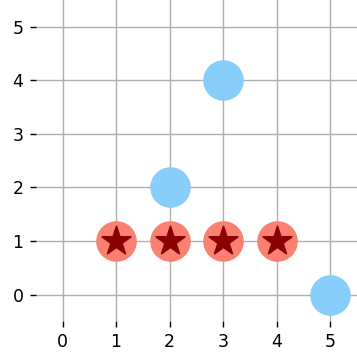

In [15]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=Policy_Player_MCTS, 
              player1=Challenge_Player_MCTS)

<IPython.core.display.Javascript object>


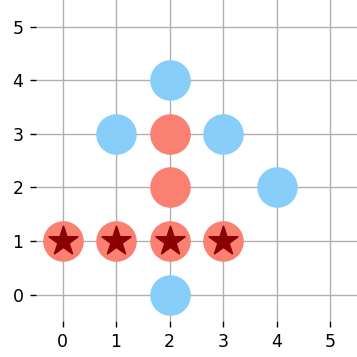

In [16]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=Challenge_Player_MCTS, 
              player1=Challenge_Player_MCTS)

<IPython.core.display.Javascript object>


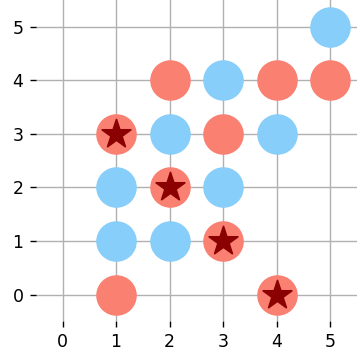

In [18]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=Challenge_Player_MCTS, 
              player1=None)